Day 2: Regularized Regression

In [1]:
# Package "glmnet" contains the LASSO function
# install.packages( 'glmnet' )
library( glmnet )

# Package "glmnetUtils" allows the use of R formulas for
# specifying glmnet models (as opposed to converting to matrices)
#library(devtools)
#install_github("hong-revo/glmnetUtils")
library(glmnetUtils)

# Metapackage "tidyverse" imports libraries 
# for data manipulation (dplyr) and plotting (ggplot2)
library( tidyverse )

# Package "skimr" has excellent descriptive statistics
# function skim_to_wide()
library( skimr )

# Package "GGally" has ggplot2-style scatterplot matrices
library( GGally )

# Package tictoc has functions to time function calls
library( tictoc )

# Library car has variance inflation factor function (vif())
library( car )

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18


Attaching package: ‘glmnetUtils’

The following objects are masked from ‘package:glmnet’:

    cv.glmnet, glmnet

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Attaching package: ‘skimr’

Th

In [2]:
library( broom )

In [3]:
options(repr.plot.width=4, repr.plot.height=3)

In [4]:
uniform_noise <- function( min, max ) { 
    runif( n=200, min, max )
}

In [5]:
gaussian_noise <- function( c=1 ) { 
    rnorm( n=200 ) * c
}

# Generate fake data

In [6]:
set.seed( 42 )

In [7]:
GenerateFake <- function (){
    Y <- uniform_noise( -10, 10 ) + 7
    X1 <- Y + gaussian_noise(1)
    X2 <- Y + gaussian_noise(2)
    X3 <- Y + gaussian_noise(4)
    trash1 <- gaussian_noise(10)
    trash2 <- gaussian_noise(10)
    trash3 <- gaussian_noise(10)
    fake_data <- data.frame( Y, X1, X2, X3, trash1, trash2, trash3 )
    return( fake_data )
}

In [8]:
fake_data <- GenerateFake()

In [9]:
library( rsample )

In [10]:
dim( fake_data )

[1] 200   7

In [11]:
skim_to_wide( fake_data )

type,variable,missing,complete,n,mean,sd,p0,p25,p50,p75,p100,hist
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
numeric,trash1,0,200,200,-0.54,9.68,-25.54,-6.76,-0.59,5.69,32.11,▁▂▅▇▅▂▁▁
numeric,trash2,0,200,200,-0.22,11,-33.72,-8.45,0.83,6.82,34.95,▁▁▅▅▇▃▁▁
numeric,trash3,0,200,200,0.59,9.74,-24.54,-5.7,0.39,6.72,26.34,▁▂▅▇▇▃▂▁
numeric,X1,0,200,200,7.4,5.92,-4.29,2.32,7.92,12.3,17.82,▃▅▆▅▇▆▇▅
numeric,X2,0,200,200,7.36,5.92,-7.35,2.3,7.81,12.36,19.11,▁▃▇▆▆▇▇▂
numeric,X3,0,200,200,7.28,7.42,-11.67,1.9,7.7,13.19,23.97,▁▃▅▇▇▇▃▂
numeric,Y,0,200,200,7.44,5.84,-3,2.17,8.11,12.22,16.78,▆▇▅▆▆▇▇▇


In [12]:
library( GGally )

In [13]:
options(repr.plot.width=6, repr.plot.height=6)

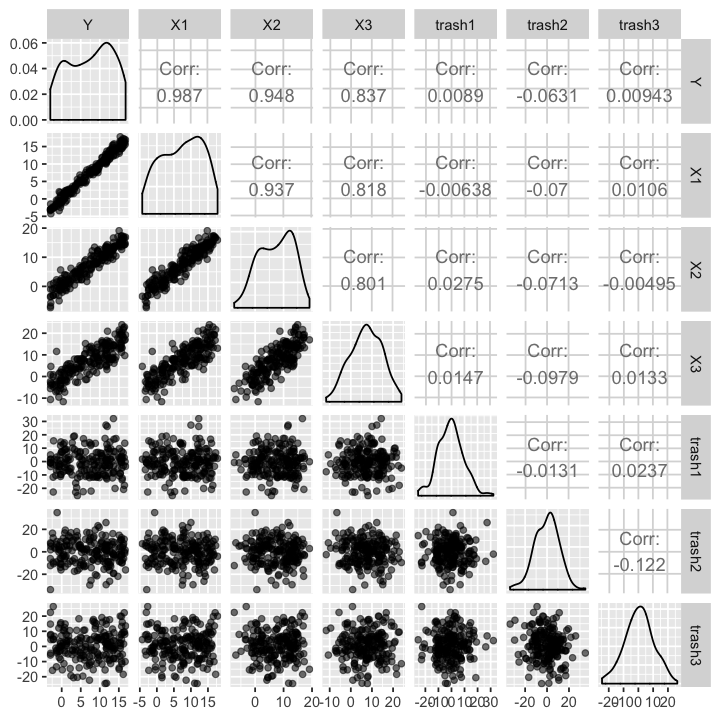

In [14]:
ggpairs( fake_data, aes( alpha=0.1) )

# Linear models

## Null model

In [15]:
model0 <- lm( Y ~ 1, fake_data )

In [16]:
summary( model0 )


Call:
lm(formula = Y ~ 1, data = fake_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4395  -5.2783   0.6639   4.7714   9.3335 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.444      0.413   18.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.84 on 199 degrees of freedom


## With one informative predictor

In [17]:
model1 <- lm( Y ~ X1, fake_data )

In [18]:
summary( model1 )


Call:
lm(formula = Y ~ X1, data = fake_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.89533 -0.52208 -0.03308  0.59546  2.35970 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.24892    0.10757   2.314   0.0217 *  
X1           0.97296    0.01136  85.619   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9495 on 198 degrees of freedom
Multiple R-squared:  0.9737,	Adjusted R-squared:  0.9736 
F-statistic:  7331 on 1 and 198 DF,  p-value: < 2.2e-16


## With additional redundant informative predictor

In [19]:
model1 <- lm( Y ~ ., fake_data )

In [20]:
summary( model1 )


Call:
lm(formula = Y ~ ., data = fake_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2072 -0.4907  0.0534  0.4554  2.9097 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.192795   0.096240   2.003   0.0465 *  
X1          0.759026   0.030510  24.878  < 2e-16 ***
X2          0.164875   0.029318   5.624 6.49e-08 ***
X3          0.058825   0.014160   4.154 4.90e-05 ***
trash1      0.004954   0.006172   0.803   0.4231    
trash2      0.005524   0.005470   1.010   0.3138    
trash3      0.001290   0.006154   0.210   0.8341    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8384 on 193 degrees of freedom
Multiple R-squared:   0.98,	Adjusted R-squared:  0.9794 
F-statistic:  1577 on 6 and 193 DF,  p-value: < 2.2e-16


## Check variance inflation factor

* High VIF means independent variables have high pairwise correlations (splom or corr)
* VIF 5-10: is danger zone
* VIF > 10: assume bad regression coefficients

In [21]:
vif( model1 )

X1       X2       X3   trash1   trash2   trash3 
9.246126 8.530524 3.124998 1.010494 1.025173 1.017907

# Multicolinearity discussion

* Want variables of interest to be reasonably independent.
* Multicolinearity increases the variance of the coefficients.
* Famous symptom of multicollinearity is having the wrong sign on the coefficients
* Another symptom: when you add or delete a factor from your model, the regression coefficients change dramatically
* Lose the explanitory part of the model.
* Ask yourself: do I care?
    * If predictive model, then no.
    * If inference estimating coefficients, then yes.
* Reduce variance of regression coefficients by adding bias.
* Regularization: penalize large coefficients betas. Pushes them to be smaller, is closer to zero.

# Regularized Regression

* Use case: wide data
* Two objectives: fit the data, AND try to drive the coefficients to zero as much as possible.
* Overfitting: the model will want to fit the noise, which results in a nonzero regression coefficient beta when there should be none.
* Three types of regularized regression: LASSO, Ridge Regression, and ElasticNet
    * In LASSO variables can have regression coefficients that become exactly zero, i.e., drop cleanly out of the analysis. Makes your model more parsimonious, interpretable.
        * Minimize $\frac{1}{N} \sum_{i=1}^N (y_i - \beta_0 - x_i^T \beta)^2$ while constraining $\sum_{j=1}^p |\beta_j| \leq \lambda$
    * In Ridge Regression, variables don't drop cleanly, but fit metrics ($R^2$) are generally better.
        * Minimize $\frac{1}{N} \sum_{i=1}^N (y_i - \beta_0 - x_i^T \beta)^2$ while constraining $\sum_{j=1}^p (\beta_j)^2 \leq \lambda$
    * ElasticNet is a mixture of LASSO and Ridge:
        * Minimize $\hat{\beta} \equiv \underset{\beta}{\operatorname{argmin}} (\| y-X \beta \|^2 + \lambda_2 \|\beta\|^2 + \lambda_1 \|\beta\|_1)$
* Different units of different predictor variables you can get different magnitudes of the fitted coefficients.
* glmnet regularization involves standardizing the variables, which also has the effect of eliminating the intercept.
* Use validation set or cross validation to find the optimal $\lambda$ for LASSO or Ridge Regression. 

## Perform LASSO using glmnet package

* glmnet will generate n different models (100 by default) with n different values of the regularization parameter ($\lambda$)
* Observe "coefficient paths": the vales of $\beta_i$ as parameter $\lambda$ varies
* A reasonable range of lambda vales are selected for you by default
    * Also you can specify your own (or a range of lambdas)
* LASSO corresponds with glmnet with argument $\alpha=1$ which is default
* glmnet standardized variables by default, so regression coefficients $\beta_i$ is interpretable as relative importances
* Use ```dfmax``` argument to limit number of variables included in the model 

In [22]:
glmnet_lm_result <- glmnet( Y ~ ., data=fake_data )

In [23]:
print( glmnet_lm_result )

Call:
glmnet.formula(formula = Y ~ ., data = fake_data)

Model fitting options:
    Sparse model matrix: FALSE
    Use model.frame: FALSE
    Alpha: 1
    Lambda summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02164 0.08738 0.35274 1.05720 1.42401 5.74874 



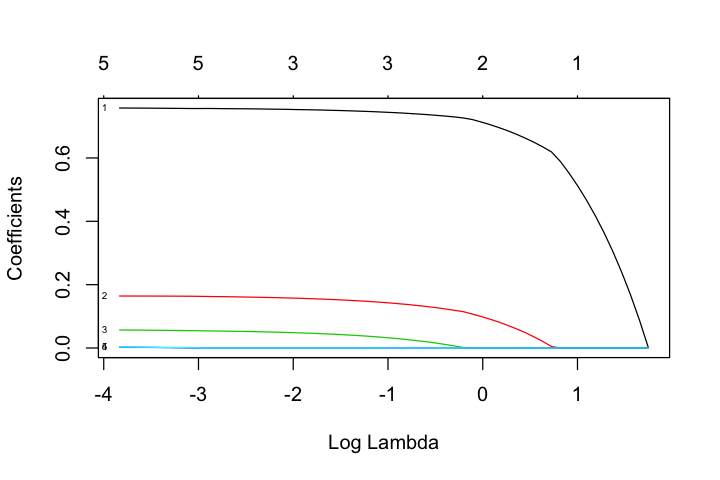

In [24]:
options(repr.plot.width=6, repr.plot.height=4)
plot( glmnet_lm_result, xvar='lambda', label=TRUE )

# Which lambda gives the best model? 

* BEST lambda is given by “lambda.min”: the λ at which the minimal MSE is achieved
* Use ```cv.glmnet()``` - Perform CROSS-VALIDATION LASSO
* 10-fold cross validation to find optimal lambda parameter

In [25]:
tic()
glmnet_cv_result <- cv.glmnet( Y ~ ., data=fake_data )
toc()

0.088 sec elapsed


In [26]:
print( glmnet_cv_result )

Call:
cv.glmnet.formula(formula = Y ~ ., data = fake_data)

Model fitting options:
    Sparse model matrix: FALSE
    Use model.frame: FALSE
    Number of crossvalidation folds: 10
    Alpha: 1
    Deviance-minimizing lambda: 0.06609653  (+1 SE): 0.2668328


In [27]:
glmnet_cv_result$lambda.min

[1] 0.06609653

In [28]:
options(repr.plot.width=6, repr.plot.height=5)

In [29]:
log( glmnet_cv_result$lambda.min )

[1] -2.716639

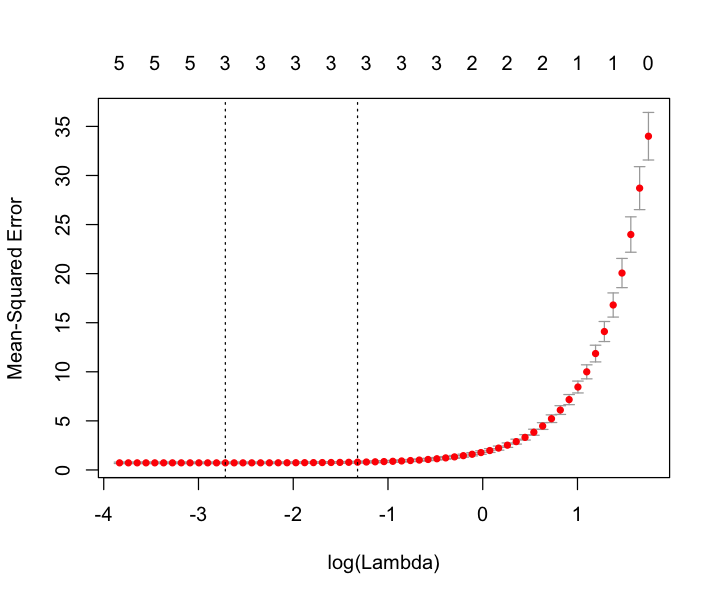

In [30]:
plot( glmnet_cv_result )